In [2]:
import pandas as pd
import os
from os.path import join
import numpy as np
import mne
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)

import h5py
from os.path import join as opj
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import tqdm
from versatile_diffusion_dual_guided_fake_images import *

from torchsummary import summary

import pandas as pd
import os
from os.path import join as opj
from PIL import Image
import h5py
import numpy as np
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#import labelencoder
from sklearn.preprocessing import LabelEncoder
#import pipeline
from sklearn.pipeline import Pipeline
import tqdm


In [19]:
base_path="/home/matteo/data/THINGS_FMRI"
stimuli_path=opj("/home/matteo/data/THINGS_img/THINGS","Images")

table_csv_path=opj(base_path,"betas_csv")

sub="sub-01"

In [4]:
metadata_df=pd.read_csv(opj(table_csv_path,f"{sub}_StimulusMetadata.csv"))
metadata_df

voxel_metadata_df=pd.read_csv(opj(table_csv_path,f"{sub}_VoxelMetadata.csv"))
voxel_metadata_df

visual_regions=["V1","V2","V3","hV4","VO1","VO2","LO1 (prf)","LO2 (prf)","TO1","TO2","V3b","V3a","lEBA","rEBA","lFFA","rFFA","lOFA","rOFA","lSTS","rSTS","lPPA","rPPA","lRSC","rRSC","lTOS","rTOS","lLOC","rLOC","IT"]

#now select only voxels in visual regions, i.e those where the corresponding column contains a 1
visual_voxels=voxel_metadata_df[voxel_metadata_df[visual_regions].any(axis=1)]

In [6]:
f=h5py.File(opj(table_csv_path,"sub-01_ResponseData.h5"), "r") 
data=np.array(f["ResponseData"]["block0_values"])
data=data[visual_voxels.voxel_id.values,:].T #select only visual voxels

In [24]:
#separate train and test set according to metadata
train_indices= metadata_df[metadata_df["trial_type"]=="train"].index.values
test_indices= metadata_df[metadata_df["trial_type"]=="test"].index.values

train_data=data[train_indices,:]
test_data=data[test_indices,:]

images_path=np.array([opj(stimuli_path,metadata_df["concept"].iloc[idx],metadata_df["stimulus"].iloc[idx]) for idx in range(len(metadata_df))])

img_train=images_path[train_indices]
img_test=images_path[test_indices]

## Create dataset

In [23]:
batch=64
device="cuda:0"

pipe_embed = VersatileDiffusionDualGuidedFromCLIPEmbeddingPipeline.from_pretrained("shi-labs/versatile-diffusion", )

pipe_embed.remove_unused_weights()
pipe_embed = pipe_embed.to(device)

Fetching 17 files: 100%|██████████| 17/17 [00:00<00:00, 85087.31it/s]


In [25]:
train_clip_img_embeds=[]


with torch.no_grad():
    for i in tqdm.tqdm(range(0,len(img_train),batch)):

        #save img data
        y= img_train[i:i+batch]
                         
        images=[Image.open(i).convert("RGB") for i in y]

        #encode images in CLIP
        image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
        train_clip_img_embeds.append(image_features)

    
        
    train_clip_img_embeds = torch.cat(train_clip_img_embeds,axis=0)



100%|██████████| 135/135 [05:21<00:00,  2.38s/it]


In [26]:

test_clip_img_embeds=[]
with torch.no_grad():
    for i in tqdm.tqdm(range(0,len(img_test),batch)):

        #save img data
        y= img_test[i:i+batch]
                         
        images=[Image.open(i).convert("RGB") for i in y]

        #encode images in CLIP
        image_features=pipe_embed._encode_image_prompt(images,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False).cpu()
        test_clip_img_embeds.append(image_features)

    
        
    test_clip_img_embeds = torch.cat(test_clip_img_embeds,axis=0)
    

100%|██████████| 19/19 [00:26<00:00,  1.40s/it]


In [112]:
## Standardize data

scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)


## Dataset

In [113]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(),train_clip_img_embeds[:,0])
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(),test_clip_img_embeds[:,0])


In [114]:
x,y=train_dataset[0]    



BS=256

clip_train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
clip_test_dataloader=DataLoader(test_dataset, batch_size=BS, shuffle=False)

x.shape, y.shape

(torch.Size([12098]), torch.Size([768]))

## Model

In [118]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim,act_fn=nn.ReLU):
        super(Encoder, self).__init__()
        
        layers = []
        prev_dim = input_dim
        if len(hidden_dims):

            for hidden_dim in hidden_dims:
                layers.append(nn.LazyLinear( hidden_dim))
                layers.append(act_fn())
            layers.append(nn.LazyLinear(output_dim))
            self.net = nn.Sequential(*layers)     
        else:
            self.net = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.net(x)

In [122]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class ContrastiveModel(pl.LightningModule):

    def contrastive_loss(self, z_i, z_j):

        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        logits = (z_i @ z_j.T) / self.temperature
        similarities = z_j @ z_j.T
        # targets = torch.nn.functional.softmax(similarities * self.temperature, dim=-1)

        targets = torch.arange(logits.shape[0]).long().to(logits.device)
        
        loss = torch.nn.functional.cross_entropy(logits, targets)
        return loss
    
    def mean_contrastive(self, z_i, z_j, temperature=1.0):
        return nn.functional.mse_loss(z_i, z_j)+self.contrastive_loss(z_i, z_j, temperature=temperature)/8
    
    def cosine_loss(self, z_i, z_j, temperature=1.0):
        cosine_similarity = torch.nn.functional.cosine_similarity(z_i, z_j).mean()
        return 1- cosine_similarity

    def __init__(self,  num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU, temperature=.1,loss_type="contrastive"):
        super().__init__()
        
        self.temperature=temperature
        
        self.model = Encoder(num_input_channels, base_channel_size, latent_dim, act_fn)

        self.loss_type=loss_type
        if loss_type=="contrastive":
            self.loss_fn=self.contrastive_loss
        elif loss_type=="mean_contrastive":
            self.loss_fn=self.mean_contrastive
        
        elif loss_type=="mse":
            self.loss_fn=torch.nn.functional.mse_loss
        elif loss_type=="cosine":
            self.loss_fn=self.cosine_loss
        
        self.train_losses = []
        self.train_mse=[]
        self.train_cosine=[]
        self.val_losses = []
        self.val_mse=[]
        self.val_cosine=[]
    
        self.train_history={}
        self.val_history={}

        #init history
        self.train_history["train_loss"]=[]
        self.train_history["train_mse"]=[]
        self.train_history["train_cosine"]=[]
        self.val_history["val_loss"]=[]
        self.val_history["val_mse"]=[]
        self.val_history["val_cosine"]=[]


    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y= batch
        # x = x.float()
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.train_losses.append(loss.item())

        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        cosine_similarity = torch.nn.functional.cosine_similarity(y_hat, y).mean()
        self.train_mse.append(mse_loss.item())
        self.train_cosine.append(cosine_similarity.item())

        return loss
    
    def on_train_epoch_end(self) -> None:
        self.train_history["train_loss"].append(np.mean(self.train_losses))
        self.train_history["train_mse"].append(np.mean(self.train_mse))
        self.train_history["train_cosine"].append(np.mean(self.train_cosine))
        self.train_losses = []
        self.train_mse=[]
        self.train_cosine=[]
        return super().on_train_epoch_end()
    
    def on_validation_epoch_end(self) -> None:
        self.val_history["val_loss"].append(np.mean(self.val_losses))
        self.val_history["val_mse"].append(np.mean(self.val_mse))
        self.val_history["val_cosine"].append(np.mean(self.val_cosine))
        self.val_losses = []

        self.val_mse=[]
        self.val_cosine=[]
        return super().on_validation_epoch_end()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # x = x.float()

        y_hat = self(x)

        loss=self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        
        mse_loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log('val_mse_loss', mse_loss, on_epoch=True, prog_bar=True)
        
        cosine_similarity = torch.nn.functional.cosine_similarity(y_hat, y).mean()
        self.log('val_cosine_similarity', cosine_similarity, on_epoch=True, prog_bar=True)
        
        self.val_losses.append(loss.item())
        self.val_mse.append(mse_loss.item())
        self.val_cosine.append(cosine_similarity.item())
        return mse_loss
        
    def configure_optimizers(self):
        # return torch.optim.AdamW(self.parameters(), lr=3e-4, weight_decay=0)
        # add a scheduler
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        # use a scheduler that every 100 steps, it will reduce the learning rate by 0.1
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}



In [123]:
brain_model = ContrastiveModel(num_input_channels= x.shape[-1], base_channel_size=[1024,768], latent_dim=768,act_fn=nn.ReLU, loss_type="contrastive")

summary(brain_model, x.shape,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      12,389,376
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 768]         787,200
              ReLU-4                  [-1, 768]               0
            Linear-5                  [-1, 768]         590,592
           Encoder-6                  [-1, 768]               0
Total params: 13,767,168
Trainable params: 13,767,168
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.04
Params size (MB): 52.52
Estimated Total Size (MB): 52.60
----------------------------------------------------------------


/home/matteo/anaconda3/envs/meg/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [124]:


# Instantiate a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=20, devices=[0])

# Train the model
trainer.fit(brain_model, clip_train_dataloader, clip_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type    | Params
----------------------------------
0 | model | Encoder | 13.8 M
----------------------------------
13.8 M    Trainable params
0         Non-trainable params
13.8 M    Total params
55.069    Total estimated model params size (MB)


/home/matteo/anaconda3/envs/meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/matteo/anaconda3/envs/meg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/matteo/anaconda3/envs/meg/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (34) is smaller than the lo

Epoch 19: 100%|██████████| 34/34 [00:00<00:00, 102.37it/s, v_num=1, train_loss_step=0.747, val_loss=5.180, val_mse_loss=0.00458, val_cosine_similarity=0.0683, train_loss_epoch=0.879]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 34/34 [00:00<00:00, 68.14it/s, v_num=1, train_loss_step=0.747, val_loss=5.180, val_mse_loss=0.00458, val_cosine_similarity=0.0683, train_loss_epoch=0.879] 


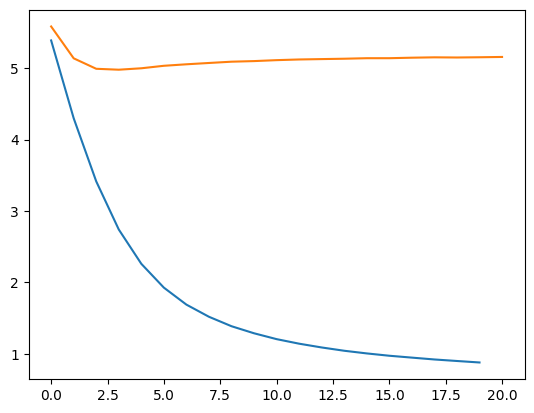

In [125]:
plt.plot(brain_model.train_history["train_loss"], label='train')
plt.plot(brain_model.val_history["val_loss"], label='val')

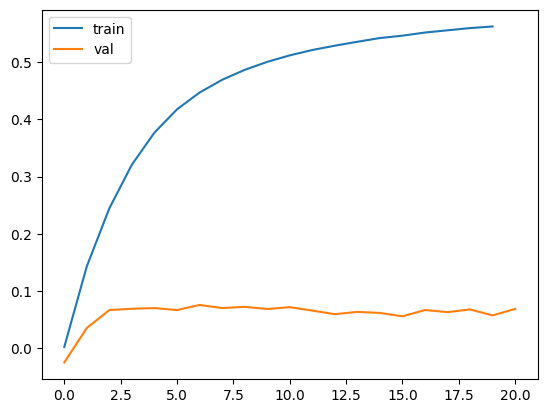

In [126]:
plt.plot(brain_model.train_history["train_cosine"], label='train')
plt.plot(brain_model.val_history["val_cosine"], label='val')

plt.legend()

In [127]:
x,y=next(iter(clip_test_dataloader))

y_pred=[]
with torch.no_grad():

    for x,y in tqdm.tqdm(clip_test_dataloader):
        y_hat=brain_model(x).cpu()
        y_pred.append(y_hat)

y_pred=torch.cat(y_pred,0)


100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


In [128]:
# similarity=  torch.nn.functional.softmax(.1*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred,.1).T)

z_i=y_pred
z_j=test_clip_img_embeds[:,0]

z_i = nn.functional.normalize(z_i, dim=1)
z_j = nn.functional.normalize(z_j, dim=1)

logits = (z_i @ z_j.T) / .1

similarity =  torch.nn.functional.softmax(logits,-1)
top_indices=torch.topk(similarity,50,1).indices
# similarity=  torch.nn.functional.softmax(10*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred.T,-1))

In [ ]:
# top_indices

In [129]:
## voglio selezionare immagini diverse!

selected_images=[]
for top_idxs in top_indices:
    selected_images.append(list(set(np.array(img_test)[top_idxs])))

In [130]:
selected_images

[['/home/matteo/data/THINGS_img/THINGS/Images/altar/altar_13s.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/grate/grate_13s.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/bed/bed_20n.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/spoon/spoon_13n.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/easel/easel_15s.jpg'],
 ['/home/matteo/data/THINGS_img/THINGS/Images/pan/pan_14s.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/mango/mango_13s.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/banana/banana_13s.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/chest1/chest1_14s.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/pear/pear_13s.jpg'],
 ['/home/matteo/data/THINGS_img/THINGS/Images/cow/cow_16n.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/cookie/cookie_15s.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/cheese/cheese_14n.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/fudge/fudge_14s.jpg',
  '/home/matteo/data/THINGS_img/THINGS/Images/bean/b

In [131]:
len(set(img_test))

100

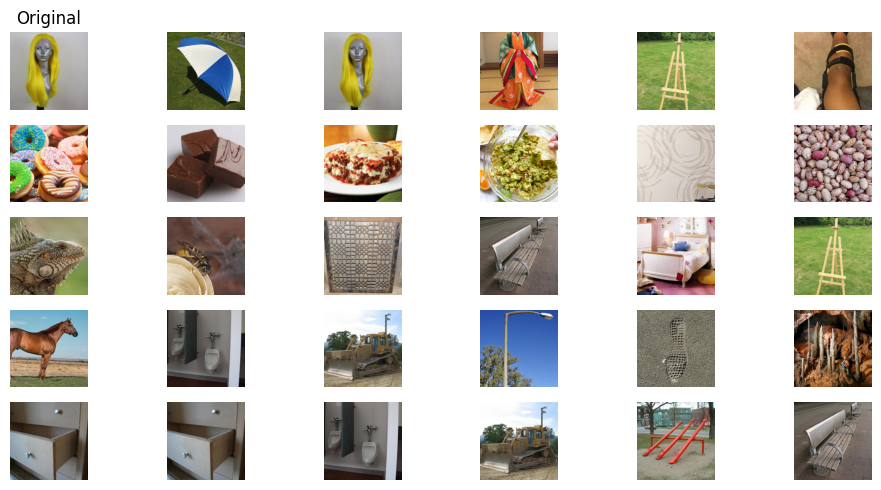

In [144]:
idx=30
fig, ax = plt.subplots(5,6,figsize=(10,5))  


for i in range(5):
    ax[i,0].imshow(Image.open(img_test[idx+i]).convert("RGB").resize((224,224)))
    ax[i,1].imshow(Image.open(selected_images[idx+i][0]).convert("RGB").resize((224,224)))

    ax[i,2].imshow(Image.open(selected_images[idx+i][1]).convert("RGB").resize((224,224)))
    ax[i,3].imshow(Image.open(selected_images[idx+i][2]).convert("RGB").resize((224,224)))
    ax[i,4].imshow(Image.open(selected_images[idx+i][3]).convert("RGB").resize((224,224)))

    ax[i,5].imshow(Image.open(selected_images[idx+i][4]).convert("RGB").resize((224,224)))

    ax[i,0].axis("off")
    ax[i,1].axis("off")
    ax[i,2].axis("off")
    ax[i,3].axis("off")
    ax[i,4].axis("off")
    ax[i,5].axis("off")

ax[0,0].set_title("Original")   


plt.tight_layout()


In [58]:
os.makedirs(f"models_contrastive_fMRI",exist_ok=True)

torch.save(brain_model, "models_contrastive_fMRI/whole_pl_model.pt")
torch.save(brain_model.state_dict(), "models_contrastive_fMRI/whole_pl_model_state_dict.pt")

torch.save(brain_model.model, "models_contrastive_fMRI/encoder.pt")
torch.save(brain_model.model.state_dict(), "models_contrastive_fMRI/encoder_state_dict.pt")


## Measure Performances

In [136]:
## measure accuracy

classes=np.array([metadata_df["concept"].iloc[idx] for idx in range(len(metadata_df))])
train_classes=classes[train_indices]
test_classes=classes[test_indices]



In [137]:
#measure accuracy
selected_classes=[]
for top_sel_imgs in selected_images:
    selected_classes.append([i.split("Images/")[1].split("/")[0] for i in top_sel_imgs])

selected_classes=np.array(selected_classes)

Text(0.5, 1.0, 'altar')

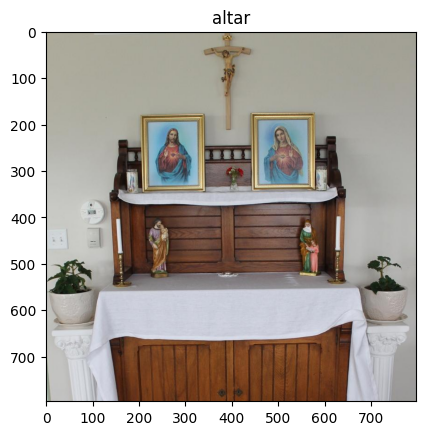

In [138]:
plt.imshow(Image.open(selected_images[0][0]))
# plt.imshow(Image.open(img_test[1]))
plt.title(selected_classes[0][0])

In [140]:
# compute accuracy

top1_accuracy=accuracy_score(test_classes,selected_classes[:,0])


#compute accuracy for top 5
top5_accuracy=[]
for i in range(len(test_classes)):
    if test_classes[i] in selected_classes[i,:5]:
        top5_accuracy.append(1)
    else:
        top5_accuracy.append(0)

top5_accuracy=np.mean(top5_accuracy)

top1_accuracy,top5_accuracy

(0.035833333333333335, 0.19583333333333333)